# Imports

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from sklearn.feature_selection import VarianceThreshold


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# Lendo Base

In [24]:
df = pd.read_csv('C:/Users/joaov/OneDrive/Área de Trabalho/Python/churn-ml-prod/data/BankChurners.csv')
df

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.999910
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.999940
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.999980
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.999870
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.999980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462,0.000191,0.999810
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,4,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511,0.995270,0.004729
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000,0.997880,0.002118
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,4,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000,0.996710,0.003294


# EDA

In [25]:
df.shape

(10127, 23)

In [26]:
df.columns

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')

In [55]:
df['FLAG_CHURN'] = df['Attrition_Flag'].apply(lambda x: 1 if x == 'Attrited Customer' else 0)
df['FLAG_CHURN'].value_counts(True)

FLAG_CHURN
0    0.83934
1    0.16066
Name: proportion, dtype: float64

In [27]:
mising = df.isna().sum() / df.shape[0] * 100
mising[mising > 0].sort_values(ascending=False)

Series([], dtype: float64)

In [68]:
def plot_cols(df):

    num_cols = df.select_dtypes(include=['float', 'int']).columns
    cat_cols = df.select_dtypes(include=['object']).columns

    for col in cat_cols:
        if col != 'Attrition_Flag':
            # Crosstab normalizado por coluna -> distribuição condicional P(valor|Attrition_Flag)
            ct = pd.crosstab(df[col], df['Attrition_Flag'], normalize='columns') * 100
            ct.plot(kind='bar', figsize=(10, 5))
            plt.xticks(rotation=0)
            plt.title(f"{col} grouped by Attrition_Flag (Percentage within Flag)")
            plt.ylabel("Percentage (%)")
            plt.show()

            # Calcular Total Variation Distance (TVD) se houver exatamente 2 classes
            if ct.shape[1] == 2:
                dist1 = ct.iloc[:, 0] / 100  # transformar em proporção
                dist2 = ct.iloc[:, 1] / 100
                tvd = 0.5 * (dist1 - dist2).abs().sum()
                print(f"Total Variation Distance for '{col}': {tvd:.2%}")


    for col in num_cols:
        plt.figure(figsize=(10, 5))
        for flag in df['Attrition_Flag'].unique():
            subset = df[df['Attrition_Flag'] == flag][col]
            sns.histplot(subset, kde=True, stat='percent', label=str(flag), bins=30, alpha=0.5)
        plt.title(f"{col} Distribution by Attrition_Flag (Percentage of Dataset)")
        plt.xlabel(col)
        plt.ylabel("Percentage (%)")
        plt.legend(title='Attrition_Flag')
        plt.show()
        
        # KS test
        flag_values = df['Attrition_Flag'].unique()
        data1 = df[df['Attrition_Flag'] == flag_values[0]][col].dropna()
        data2 = df[df['Attrition_Flag'] == flag_values[1]][col].dropna()
        ks_stat, ks_pvalue = ks_2samp(data1, data2)
        print(f"KS statistic for {col}: {ks_stat:.2%}, p-value: {ks_pvalue:.2f}")

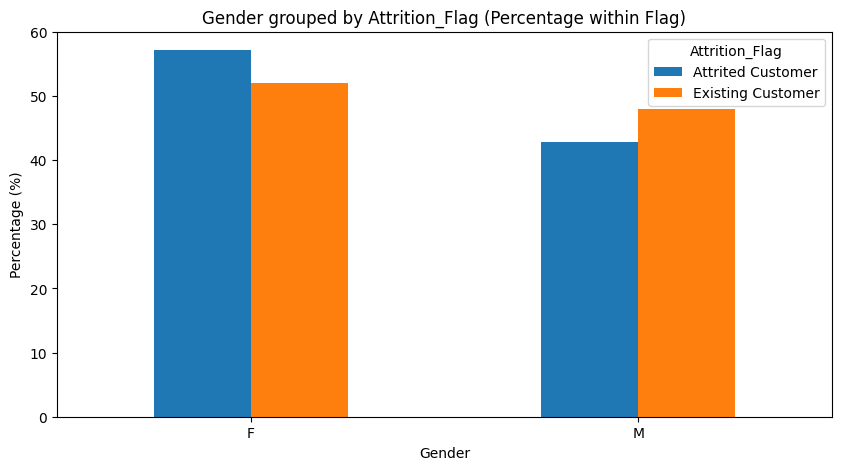

Total Variation Distance for 'Gender': 5.07%


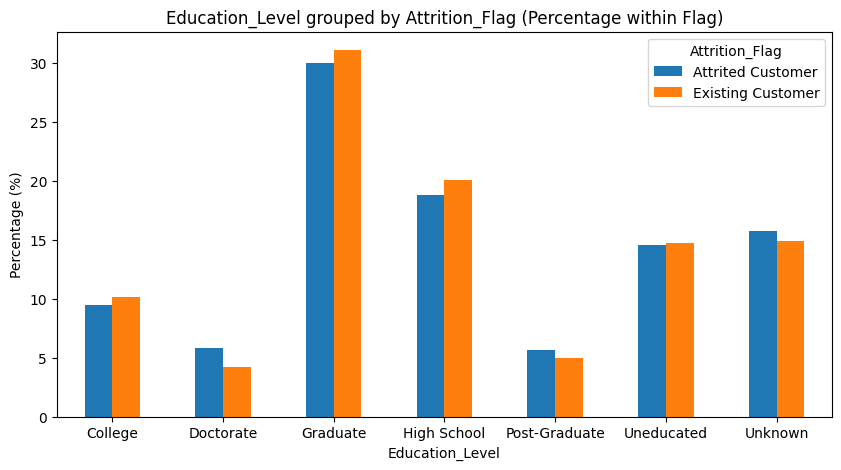

Total Variation Distance for 'Education_Level': 3.19%


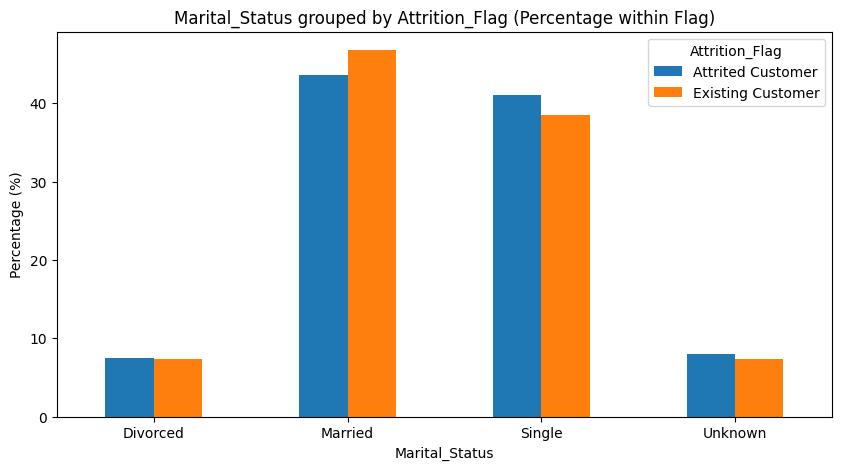

Total Variation Distance for 'Marital_Status': 3.22%


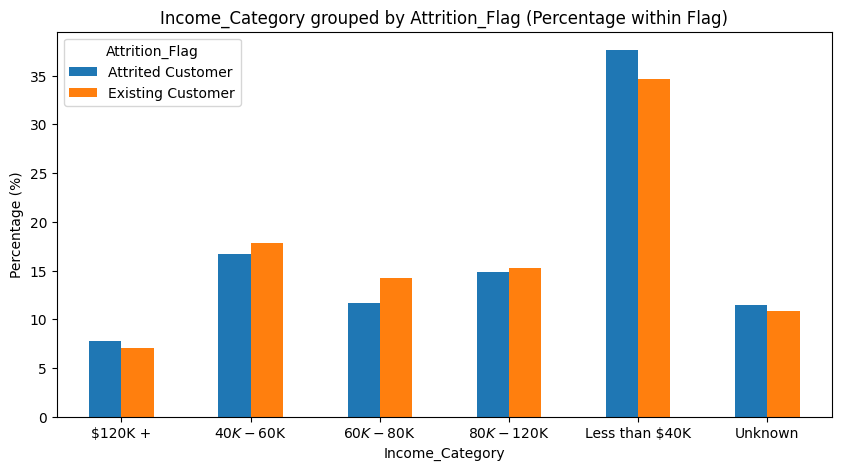

Total Variation Distance for 'Income_Category': 4.21%


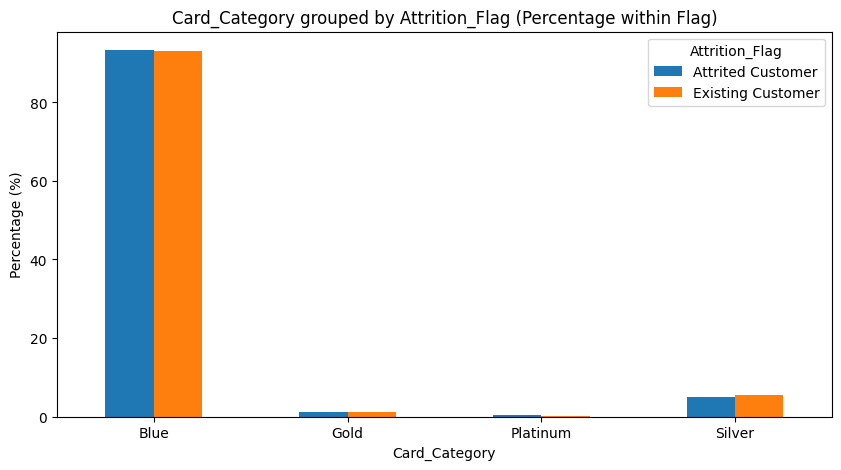

Total Variation Distance for 'Card_Category': 0.52%


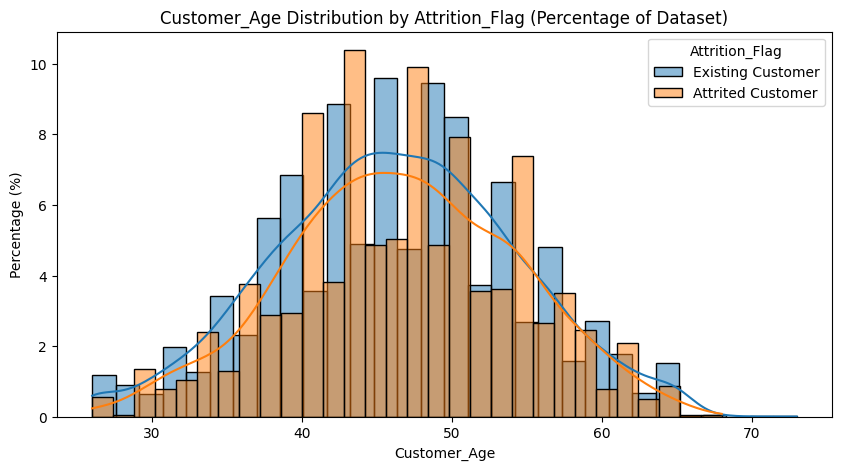

KS statistic for Customer_Age: 3.60%, p-value: 0.06


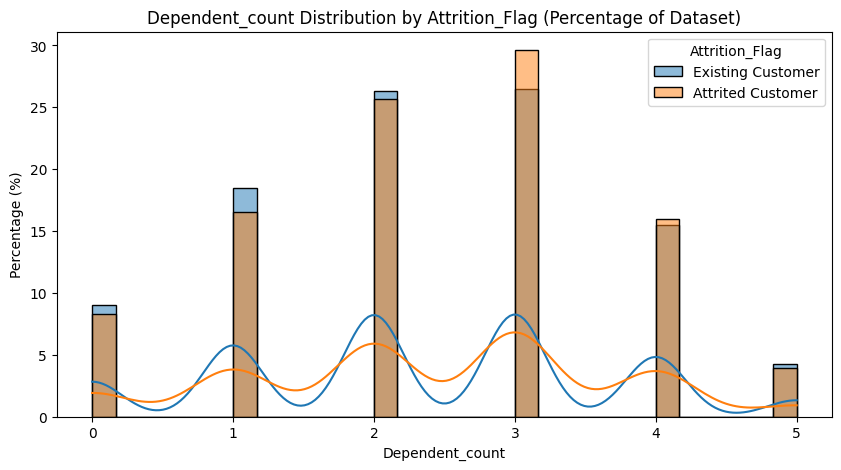

KS statistic for Dependent_count: 3.37%, p-value: 0.09


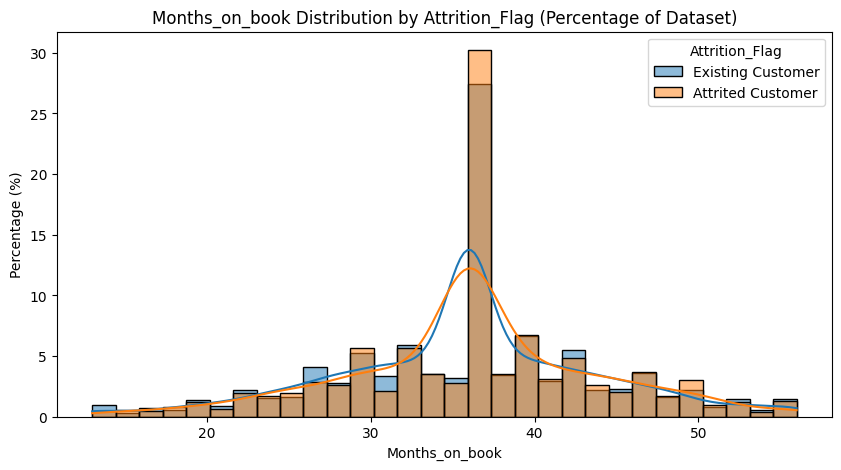

KS statistic for Months_on_book: 3.21%, p-value: 0.12


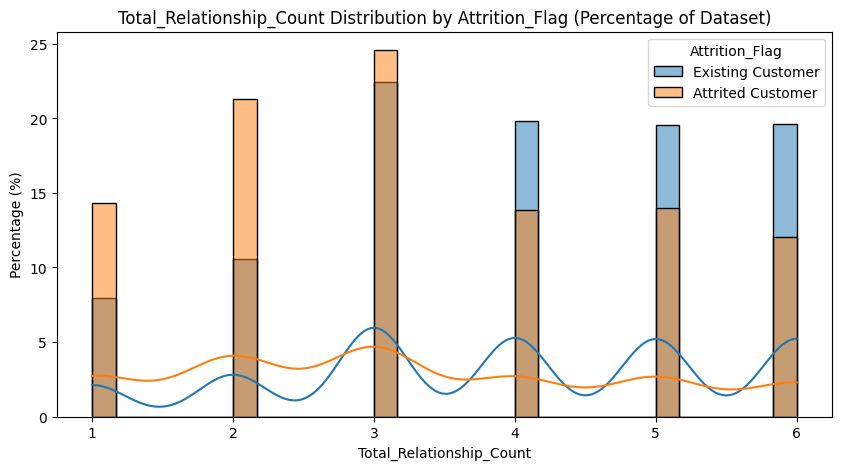

KS statistic for Total_Relationship_Count: 19.24%, p-value: 0.00


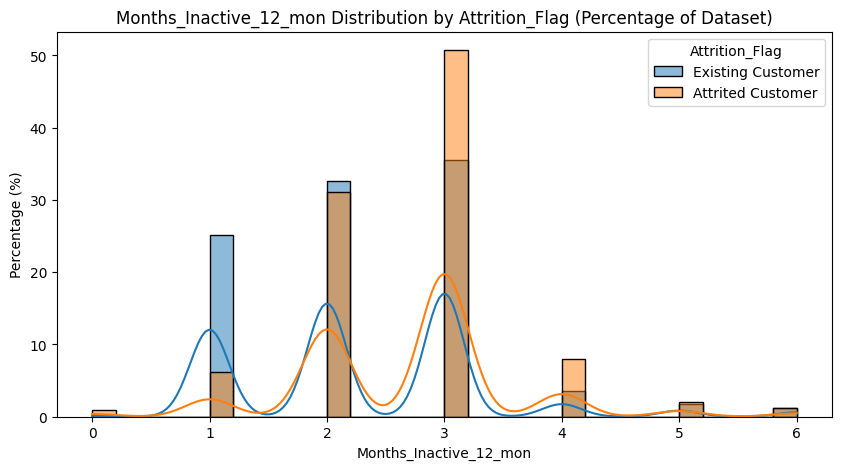

KS statistic for Months_Inactive_12_mon: 19.82%, p-value: 0.00


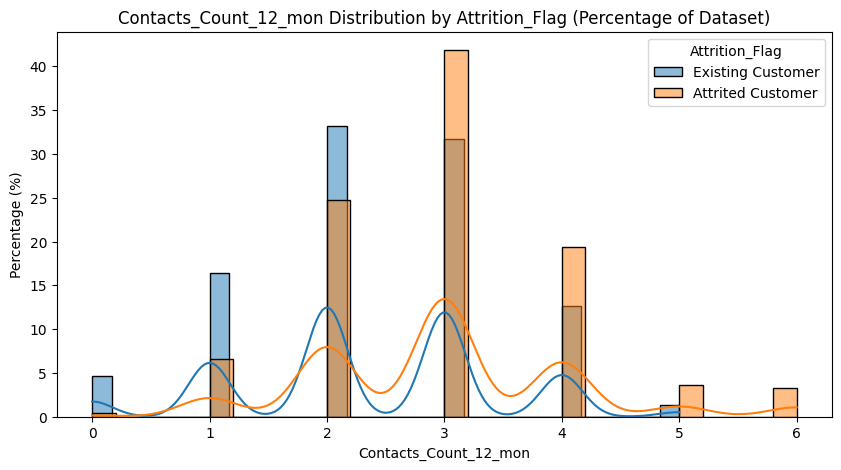

KS statistic for Contacts_Count_12_mon: 22.36%, p-value: 0.00


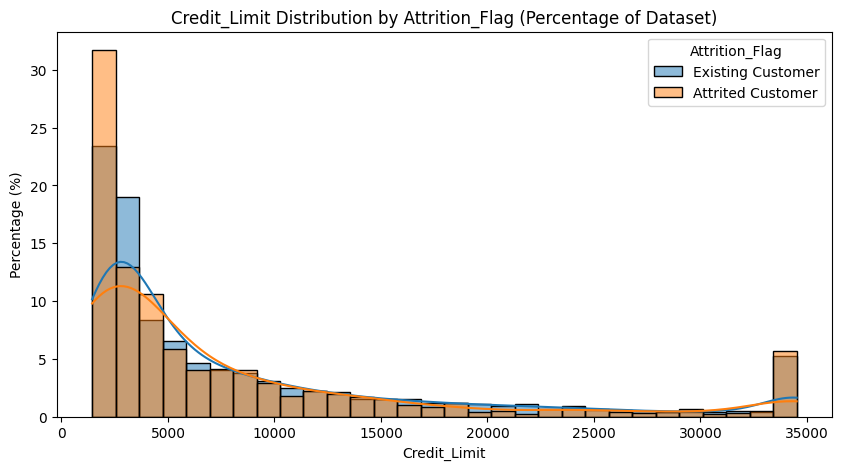

KS statistic for Credit_Limit: 11.61%, p-value: 0.00


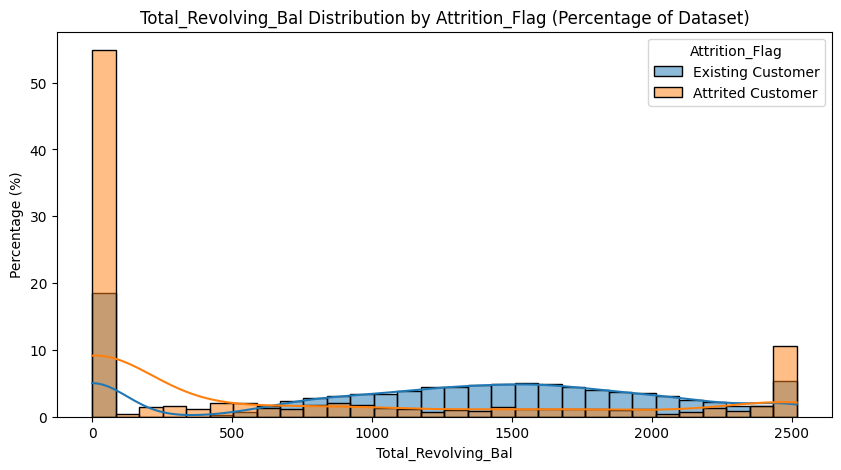

KS statistic for Total_Revolving_Bal: 44.37%, p-value: 0.00


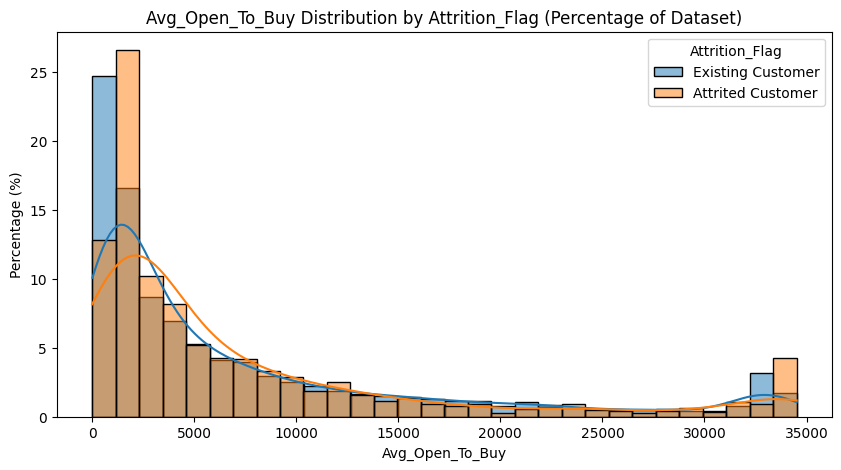

KS statistic for Avg_Open_To_Buy: 13.25%, p-value: 0.00


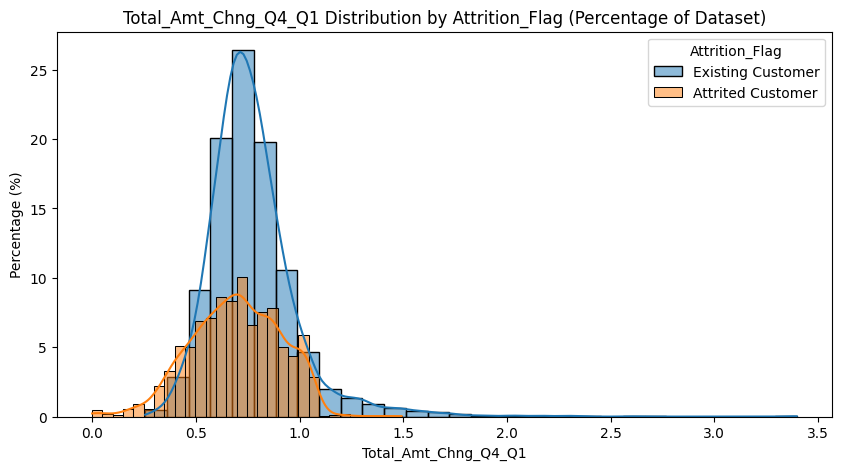

KS statistic for Total_Amt_Chng_Q4_Q1: 16.73%, p-value: 0.00


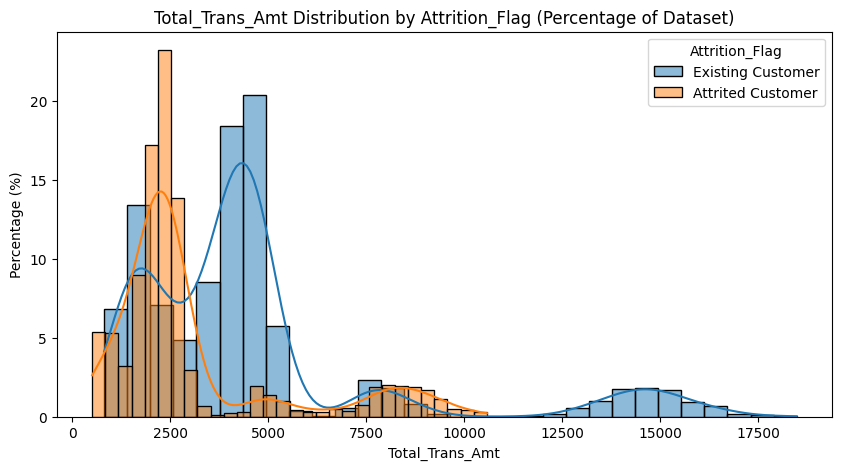

KS statistic for Total_Trans_Amt: 48.46%, p-value: 0.00


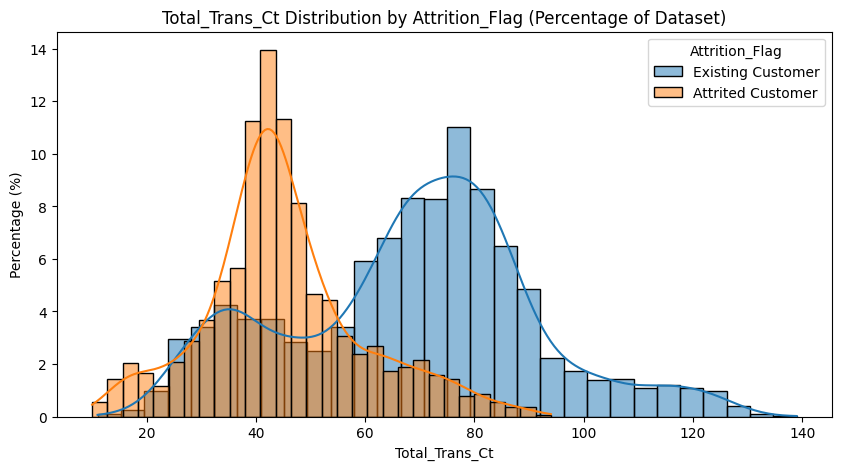

KS statistic for Total_Trans_Ct: 55.05%, p-value: 0.00


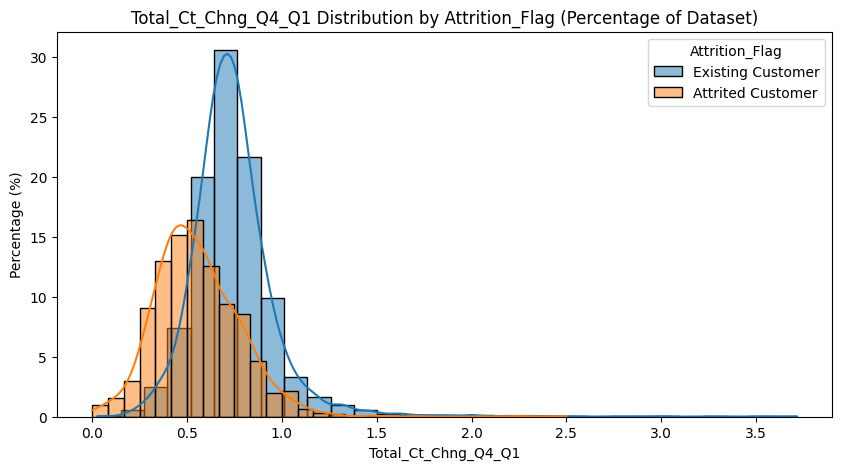

KS statistic for Total_Ct_Chng_Q4_Q1: 41.13%, p-value: 0.00


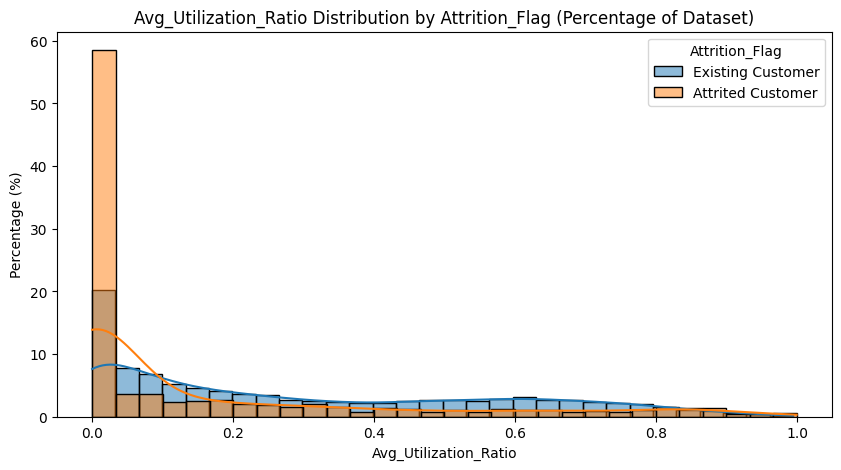

KS statistic for Avg_Utilization_Ratio: 38.38%, p-value: 0.00


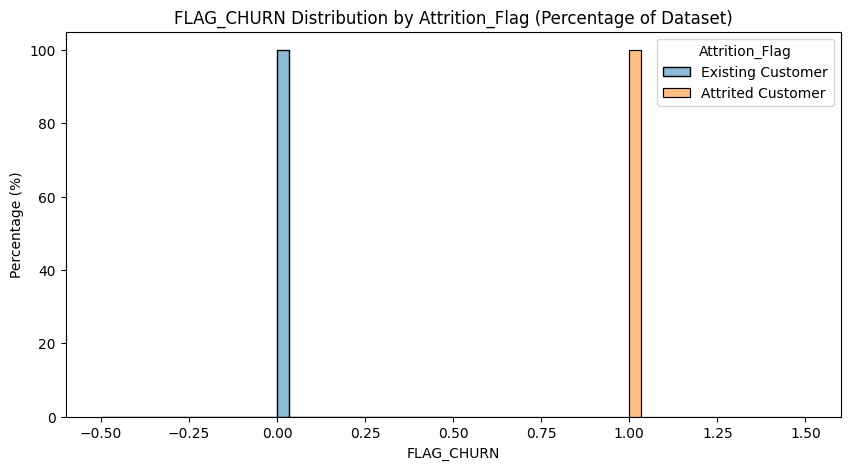

KS statistic for FLAG_CHURN: 100.00%, p-value: 0.00


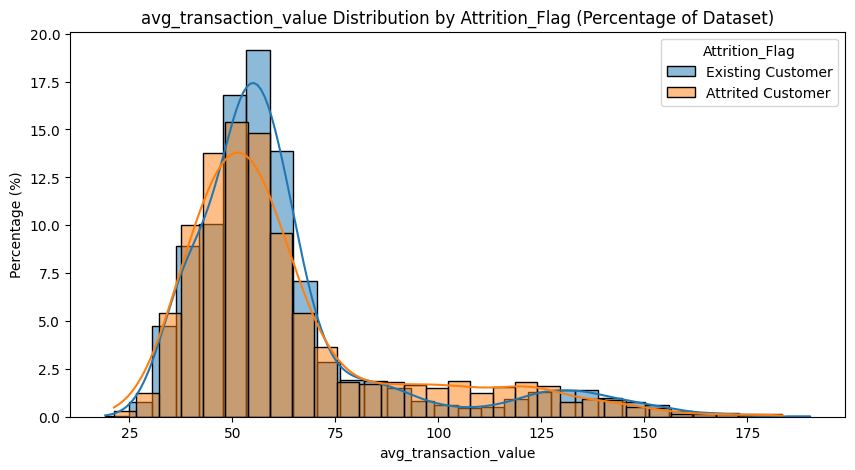

KS statistic for avg_transaction_value: 5.18%, p-value: 0.00


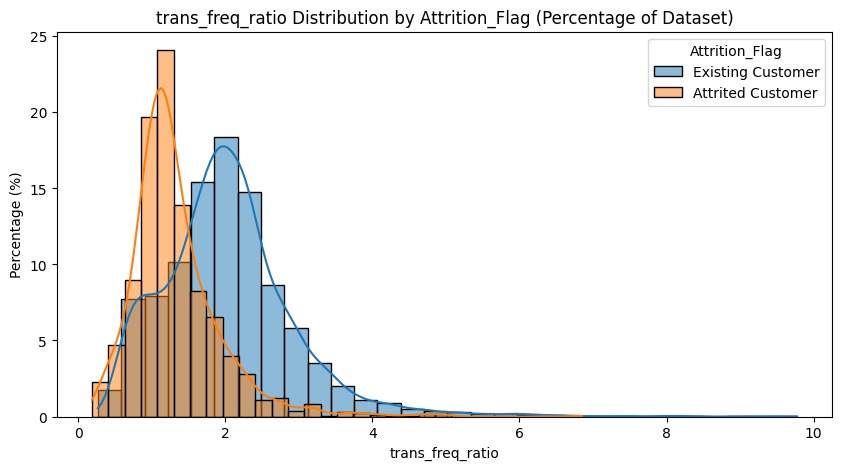

KS statistic for trans_freq_ratio: 47.43%, p-value: 0.00


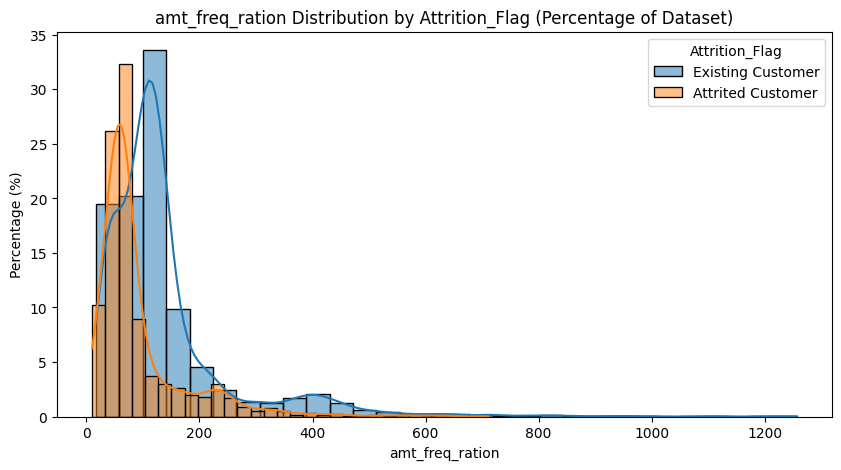

KS statistic for amt_freq_ration: 42.31%, p-value: 0.00


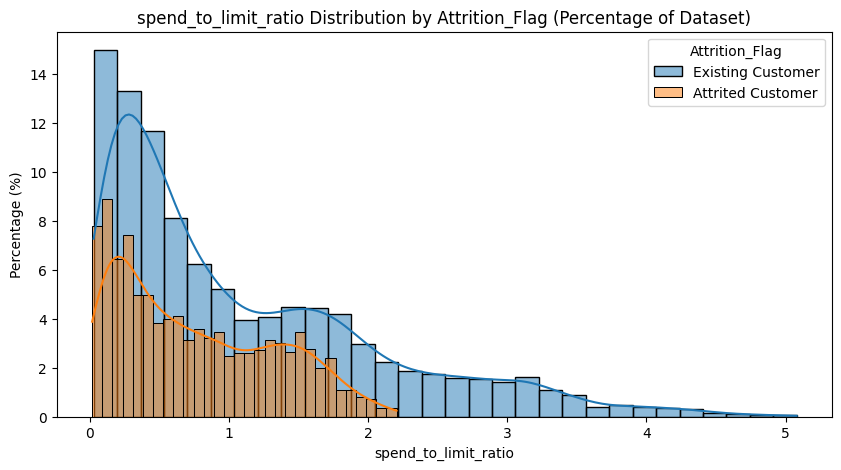

KS statistic for spend_to_limit_ratio: 17.71%, p-value: 0.00


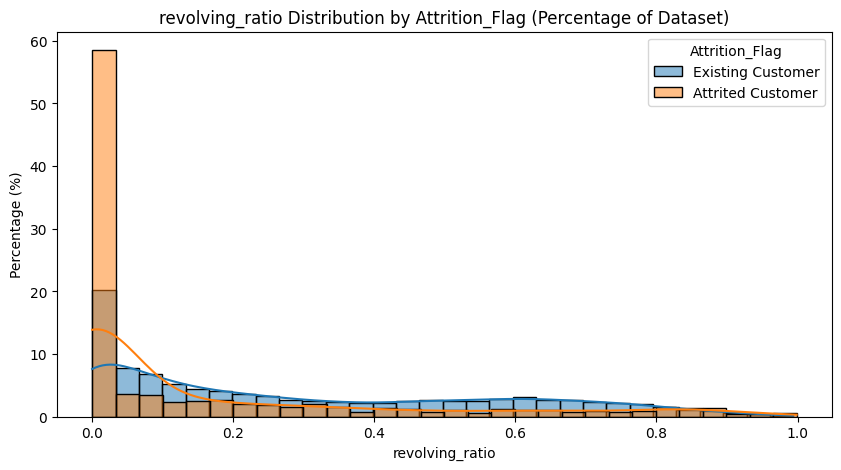

KS statistic for revolving_ratio: 38.47%, p-value: 0.00


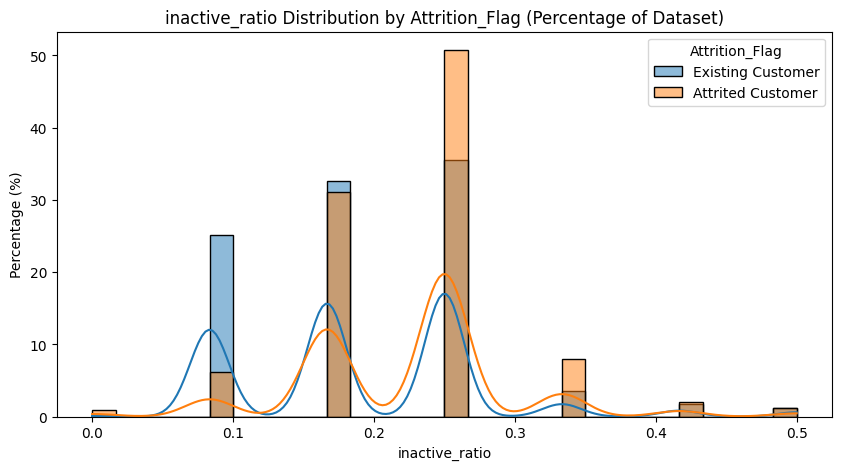

KS statistic for inactive_ratio: 19.82%, p-value: 0.00


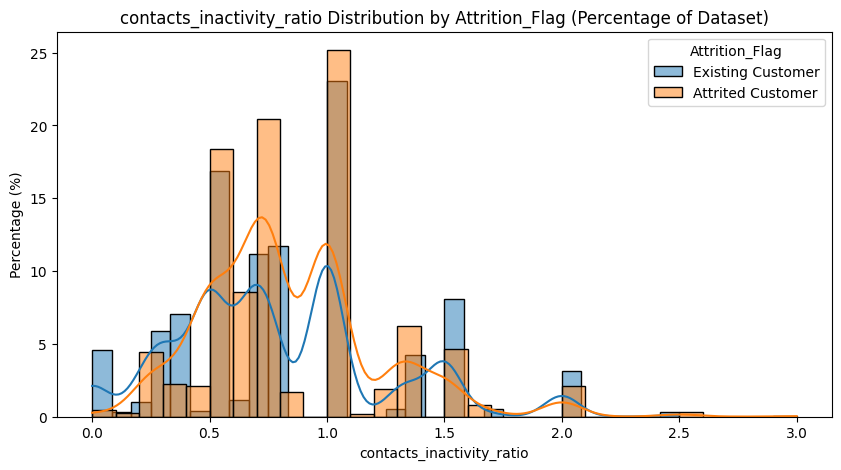

KS statistic for contacts_inactivity_ratio: 12.43%, p-value: 0.00


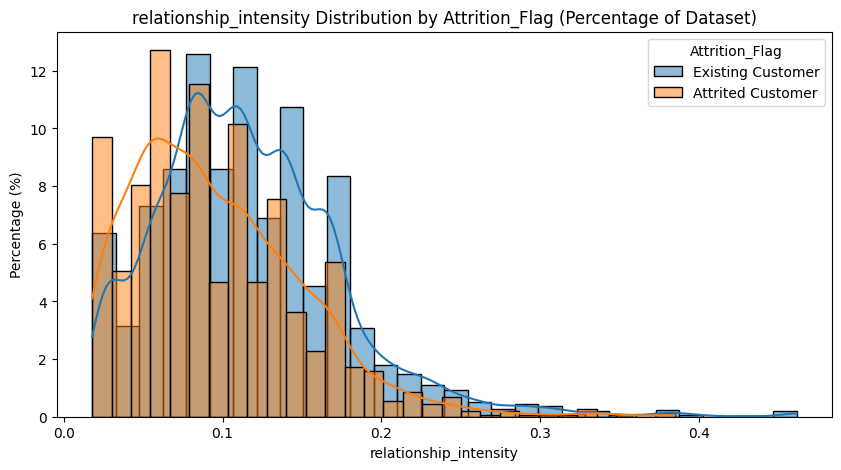

KS statistic for relationship_intensity: 17.39%, p-value: 0.00


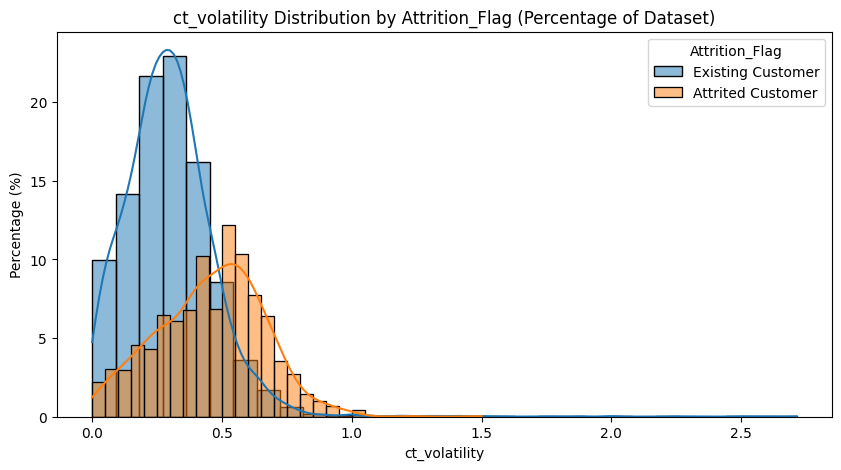

KS statistic for ct_volatility: 40.05%, p-value: 0.00


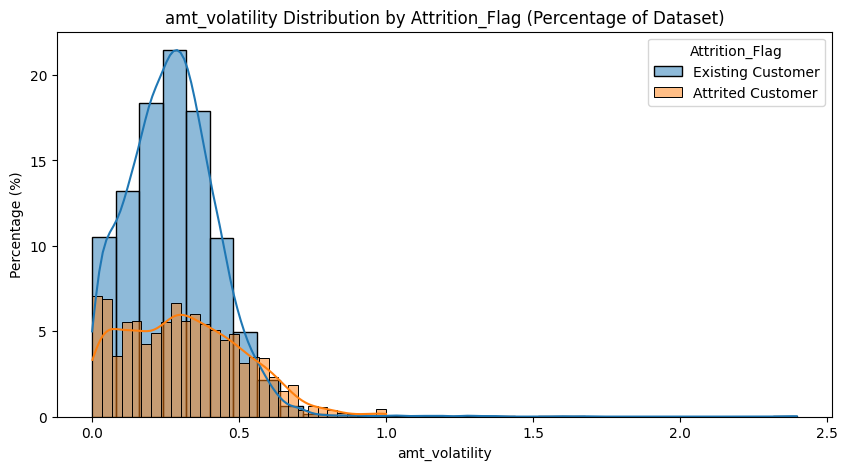

KS statistic for amt_volatility: 15.02%, p-value: 0.00


In [70]:
plot_cols(df.drop(['CLIENTNUM', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis=1))

Text(0.5, 1.0, 'Correlation Matrix')

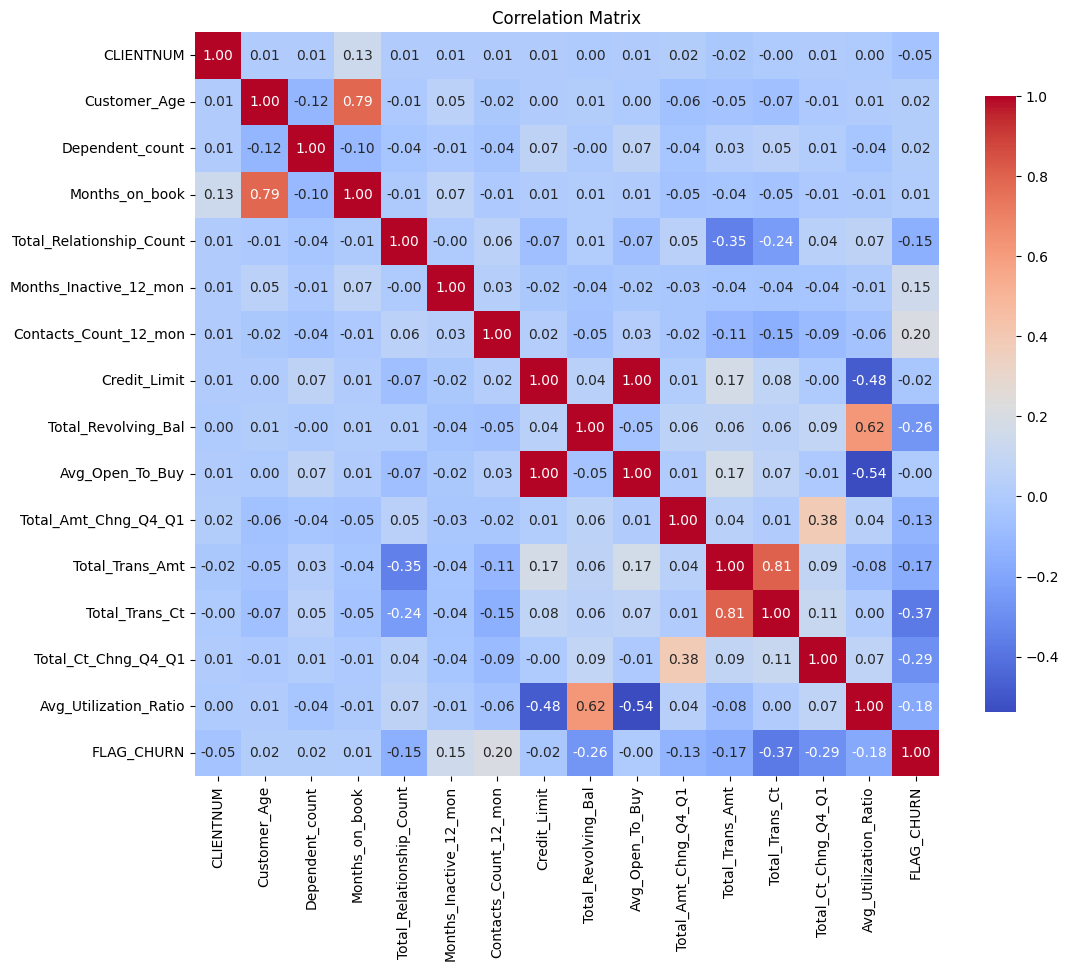

In [61]:
corr = df.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',
                'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1'], axis=1).select_dtypes(include=['int', 'float']).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix")

# Feature Engineering

In [73]:
feats= ['avg_transaction_value', 'trans_freq_ratio', 'amt_freq_ration', 'spend_to_limit_ratio', 'revolving_ratio', 'inactive_ratio', 'contacts_inactivity_ratio', 'relationship_intensity', 'ct_volatility', 'amt_volatility']
df['avg_transaction_value'] = df['Total_Trans_Amt'] / df['Total_Trans_Ct']
df['trans_freq_ratio'] = df['Total_Trans_Ct'] / df['Months_on_book']
df['amt_freq_ration'] = df['Total_Trans_Amt'] / df['Months_on_book']
df['spend_to_limit_ratio'] = df['Total_Trans_Amt'] / df['Credit_Limit']
df['revolving_ratio'] = df['Total_Revolving_Bal'] / df['Credit_Limit']
df['inactive_ratio'] = df['Months_Inactive_12_mon'] / 12
df['contacts_inactivity_ratio'] = df['Contacts_Count_12_mon'] / (df['Months_Inactive_12_mon'].replace(0, np.nan) + 1)
df['relationship_intensity'] = df['Total_Relationship_Count'] / df['Months_on_book']
df['ct_volatility'] = abs(df['Total_Ct_Chng_Q4_Q1'] - 1)
df['amt_volatility'] = abs(df['Total_Amt_Chng_Q4_Q1'] - 1)

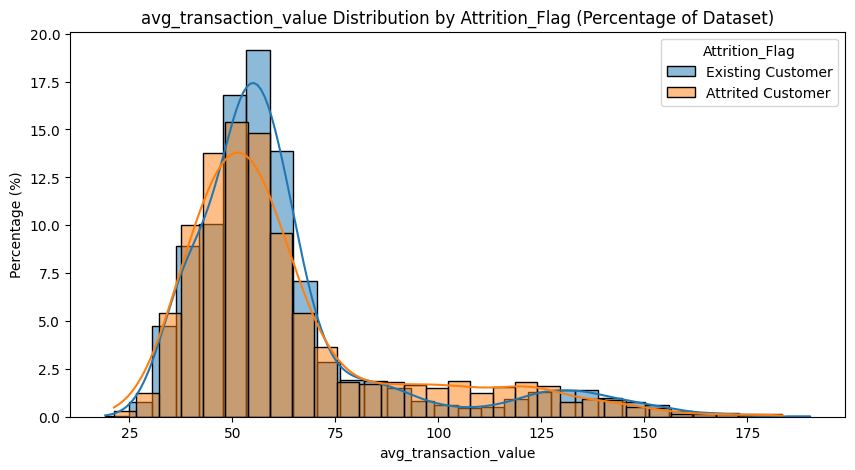

KS statistic for avg_transaction_value: 5.18%, p-value: 0.00


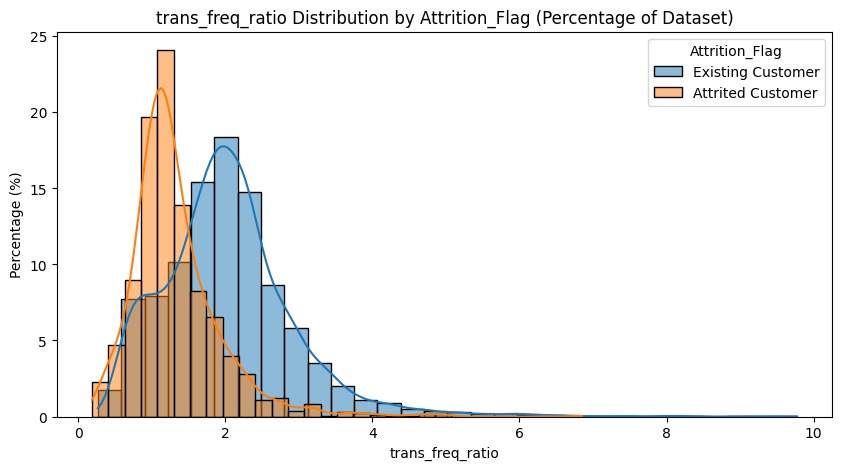

KS statistic for trans_freq_ratio: 47.43%, p-value: 0.00


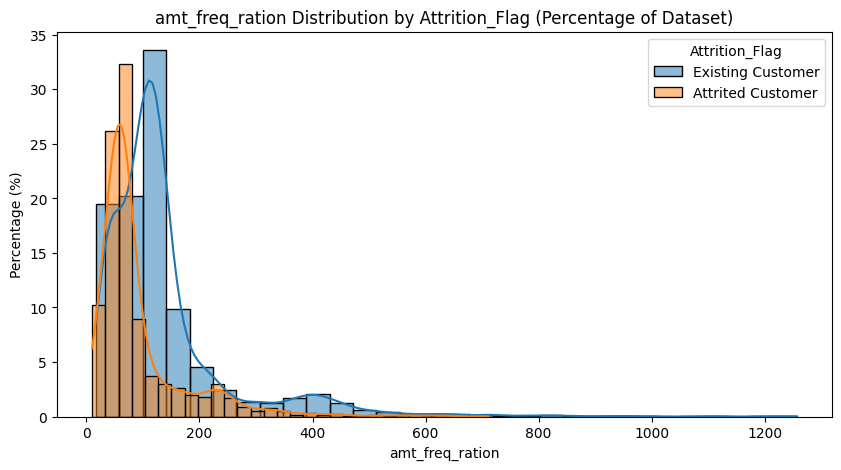

KS statistic for amt_freq_ration: 42.31%, p-value: 0.00


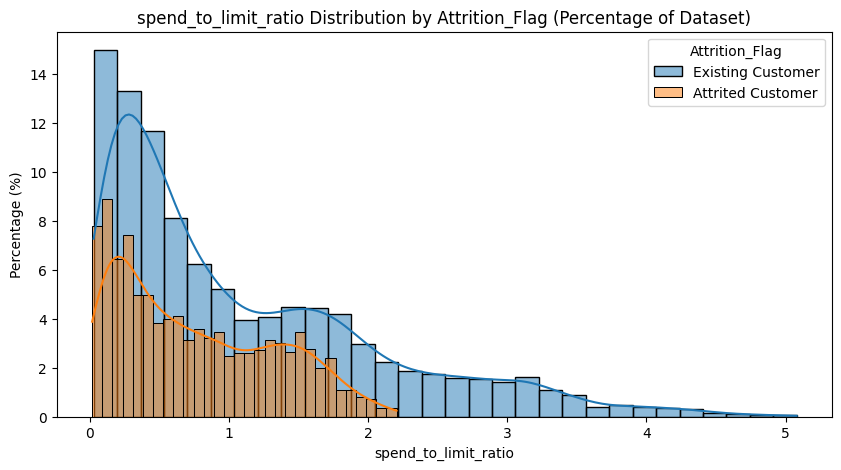

KS statistic for spend_to_limit_ratio: 17.71%, p-value: 0.00


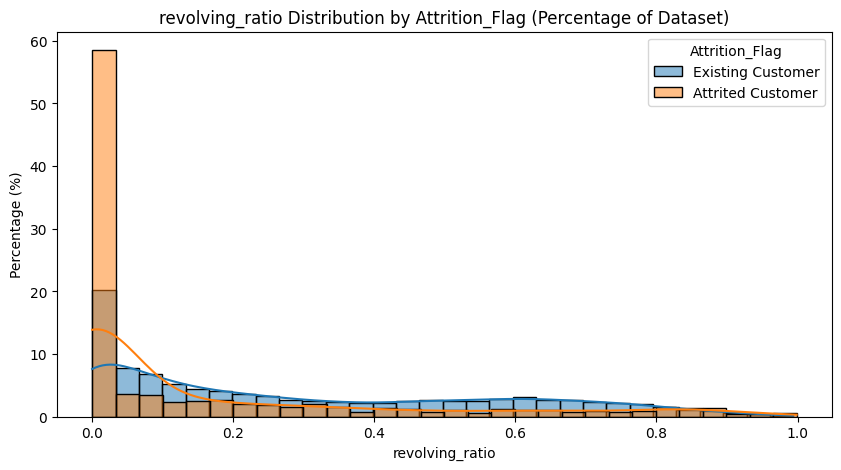

KS statistic for revolving_ratio: 38.47%, p-value: 0.00


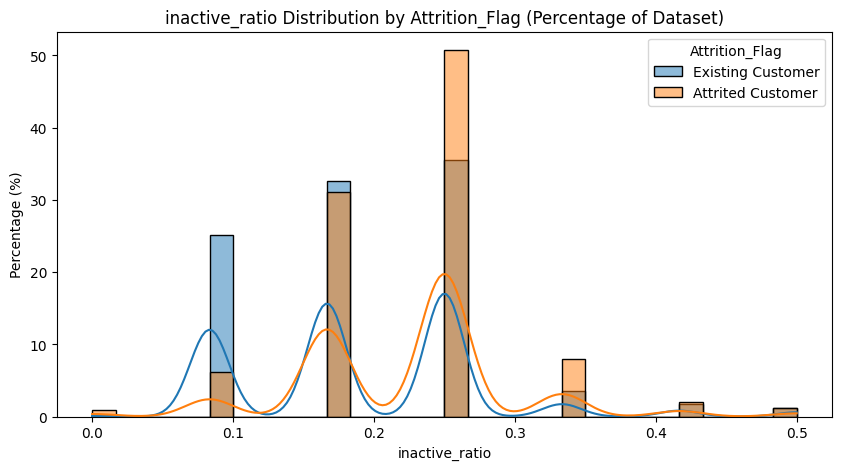

KS statistic for inactive_ratio: 19.82%, p-value: 0.00


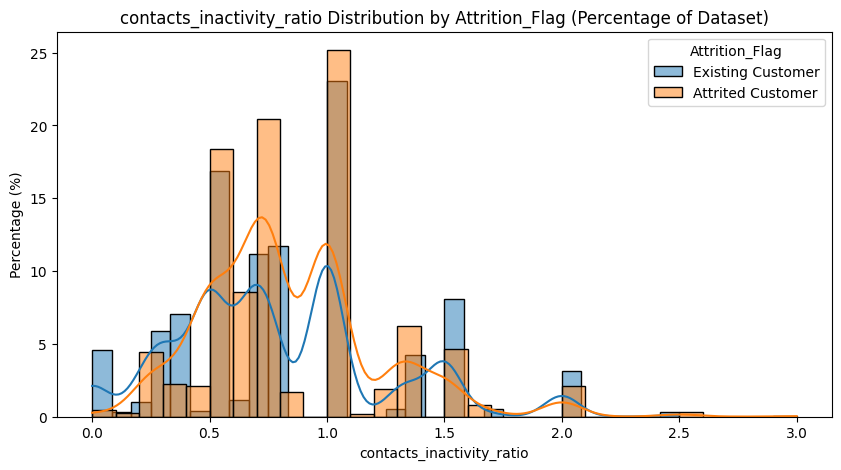

KS statistic for contacts_inactivity_ratio: 12.43%, p-value: 0.00


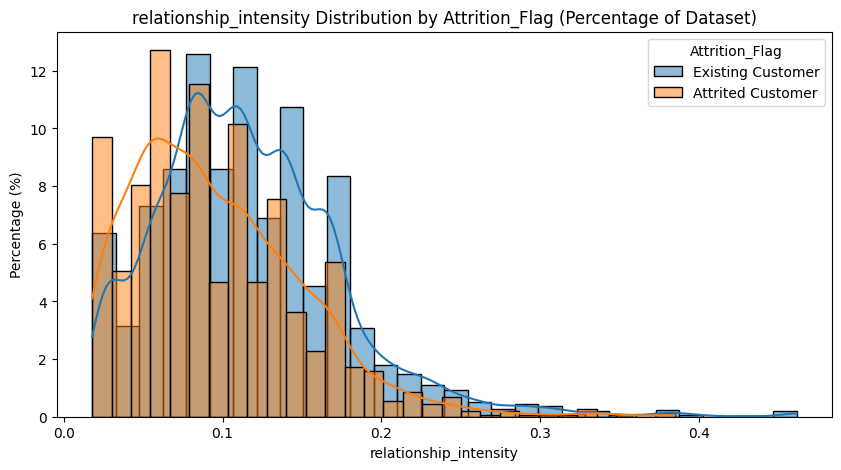

KS statistic for relationship_intensity: 17.39%, p-value: 0.00


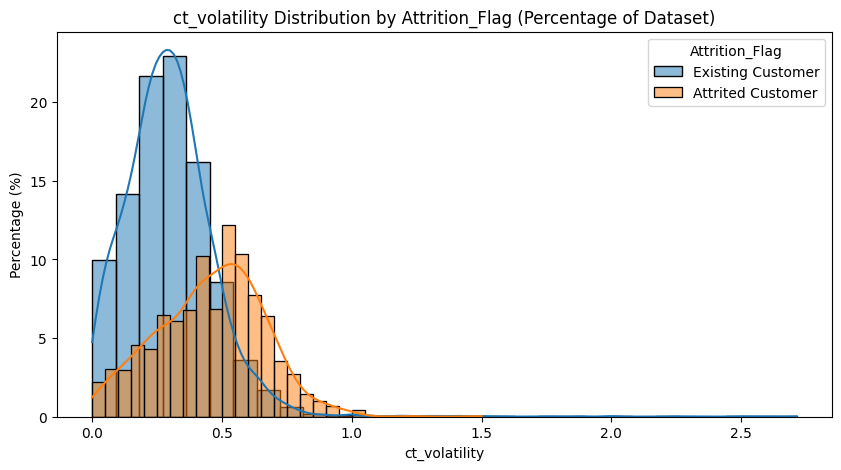

KS statistic for ct_volatility: 40.05%, p-value: 0.00


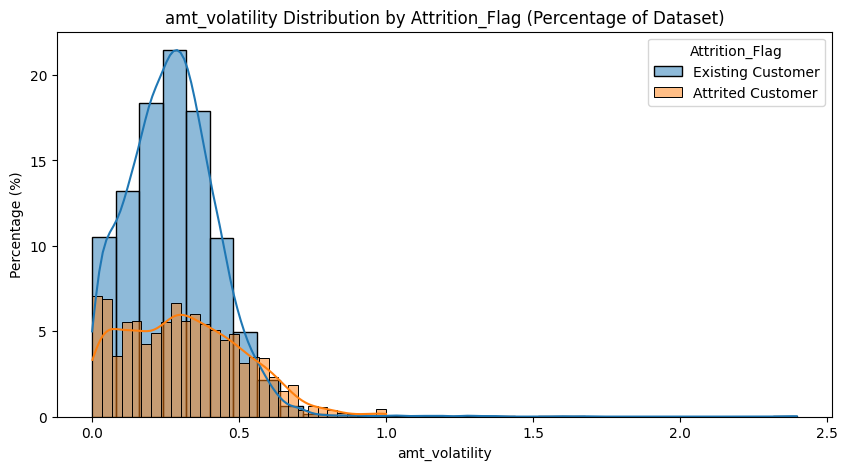

KS statistic for amt_volatility: 15.02%, p-value: 0.00


In [75]:
plot_cols(df[feats + ['Attrition_Flag']])